In [1]:
import pandas as pd
from datetime import datetime, timedelta
from osgeo import gdal
import numpy as np
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input, Concatenate, Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from dateutil.parser import parse
import subprocess
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from pandas import Series
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join
import tensorflow as tf
from joblib import dump, load


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [4]:
MAIAC_TRAINING_DATA_PATH = "./Data/maiac_satellite_data/train/"
TRAINING_LABELS_CSV_PATH = "./Data/train_labels.csv"
SATELLITE_METADATA_CSV_PATH = "./Data/satellite_metadata.csv"
GRID_METADATA_CSV_PATH = "./Data/grid_metadata.csv"
ELEVATION_DATA_CSV_PATH = "./Data/elevation_data.csv"
GFS_FORECAST_DATA_CSV_PATH = './Data/cleaned_gfs_data.csv'

### Import Data + Competition Files

In [5]:
all_train_labels = pd.read_csv(TRAINING_LABELS_CSV_PATH)
grid_metadata = pd.read_csv(GRID_METADATA_CSV_PATH)
satellite_metadata = pd.read_csv(SATELLITE_METADATA_CSV_PATH)
satellite_metadata['Date'] =  pd.to_datetime(satellite_metadata['time_end'], format='%Y-%m-%d')

In [6]:
elevation_data = pd.read_csv(ELEVATION_DATA_CSV_PATH)
scaler = StandardScaler(with_mean=True, with_std=True)
scaled = scaler.fit_transform(np.array(elevation_data['elevations']).reshape(-1, 1))
elevation_data['scaled_elevation'] = scaled

In [7]:
gfs_data = pd.read_csv(GFS_FORECAST_DATA_CSV_PATH)

### Example MAIAC Satellite Photo - AOD Data

In [8]:
# Opens the HDF file
def load_data(FILEPATH):
    ds = gdal.Open(FILEPATH)
    return ds

In [9]:
ds = load_data("./Data/maiac_satellite_data/train/20180207T201000_maiac_la_0.hdf")
ds.GetSubDatasets()[0]
raster = gdal.Open(ds.GetSubDatasets()[8][0]) #grid5km:cosSZA features only
band = raster.GetRasterBand(1)
band_arr = band.ReadAsArray()

In [10]:
ds.GetMetadata()

{'ADDITIONALLAYERS': '5',
 'ALGORITHMPACKAGEACCEPTANCEDATE': 'TBD',
 'ALGORITHMPACKAGEMATURITYCODE': 'Preliminary',
 'ALGORITHMPACKAGENAME': 'MOD_PR19',
 'ALGORITHMPACKAGEVERSION': '2.0',
 'ASSOCIATEDINSTRUMENTSHORTNAME.1': 'MODIS',
 'ASSOCIATEDINSTRUMENTSHORTNAME.2': 'MODIS',
 'ASSOCIATEDPLATFORMSHORTNAME.1': 'Terra',
 'ASSOCIATEDPLATFORMSHORTNAME.2': 'Aqua',
 'ASSOCIATEDSENSORSHORTNAME.1': 'MODIS',
 'ASSOCIATEDSENSORSHORTNAME.2': 'MODIS',
 'AUTOMATICQUALITYFLAG.1': 'Passed',
 'AUTOMATICQUALITYFLAGEXPLANATION.1': 'output file is created and good',
 'CHARACTERISTICBINANGULARSIZE': '30.0',
 'CHARACTERISTICBINSIZE': '926.625433055556',
 'DATACOLUMNS': '1200',
 'DATAROWS': '1200',
 'DAYNIGHTFLAG': 'Day',
 'DESCRREVISION': '6.1',
 'EASTBOUNDINGCOORDINATE': '-103.913425937493',
 'EQUATORCROSSINGDATE.1': '2018-02-07',
 'EQUATORCROSSINGLONGITUDE.1': '-121.600153644046',
 'EQUATORCROSSINGTIME.1': '18:36:57.030135',
 'EXCLUSIONGRINGFLAG.1': 'N',
 'GEOANYABNORMAL': 'False',
 'GEOESTMAXRMSERROR':

In [11]:
ds.GetMetadata()['GRINGPOINTLONGITUDE.1']

'-115.369550008828, -130.540728914638, -117.360631853124, -103.699828723654'

In [12]:
ds.GetMetadata()['GRINGPOINTLATITUDE.1']

'29.8308028608368, 39.9999999964079, 40.0852255853565, 29.9062514942912'

In [13]:
for path, desc in ds.GetSubDatasets():
    print(desc)

[4x1200x1200] Optical_Depth_047 grid1km (16-bit integer)
[4x1200x1200] Optical_Depth_055 grid1km (16-bit integer)
[4x1200x1200] AOD_Uncertainty grid1km (16-bit integer)
[4x1200x1200] FineModeFraction grid1km (16-bit integer)
[4x1200x1200] Column_WV grid1km (16-bit integer)
[4x1200x1200] AOD_QA grid1km (16-bit unsigned integer)
[4x1200x1200] AOD_MODEL grid1km (8-bit unsigned integer)
[4x1200x1200] Injection_Height grid1km (32-bit floating-point)
[4x240x240] cosSZA grid5km (16-bit integer)
[4x240x240] cosVZA grid5km (16-bit integer)
[4x240x240] RelAZ grid5km (16-bit integer)
[4x240x240] Scattering_Angle grid5km (16-bit integer)
[4x240x240] Glint_Angle grid5km (16-bit integer)


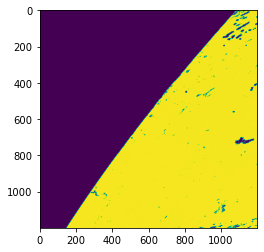

In [14]:
example_subset = gdal.Open(ds.GetSubDatasets()[0][0])
example_subset_array = example_subset.GetRasterBand(2).ReadAsArray()
plt.imshow(example_subset_array)

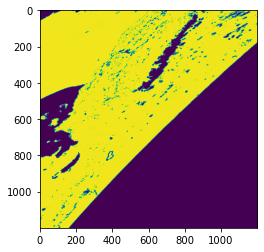

In [15]:
example_subset = gdal.Open(ds.GetSubDatasets()[0][0])
example_subset_array = example_subset.GetRasterBand(4).ReadAsArray()
plt.imshow(example_subset_array)

### Training Functions

In [16]:
def get_grid_data(metadata, grid_id):
    return metadata[metadata["grid_id"] == grid_id]

In [17]:
def fetch_satellite_meta(metadata, datetime, location, datatype, split, n_days_previous=None):
    
    
    if location == "Delhi":
        location = "dl"
    elif location == "Taipei":
        location = "tpe"
    else:
        location = "la"

    metadata = metadata[metadata['location'] == location]
    metadata = metadata[metadata['product'] == datatype]
    metadata = metadata[metadata['split'] == split]
    dateobject = parse(datetime)
    
    if n_days_previous is not None:
        start_dateobject = dateobject - timedelta(days=n_days_previous)
        end_dateobject = dateobject- timedelta(days=1)
        
        metadata = metadata.loc[(metadata['Date'].dt.date >= start_dateobject.date()) & 
                                (metadata['Date'].dt.date <= end_dateobject.date())]

    if n_days_previous is None:
        
        # Get closest date less than 
        metadata  = metadata.loc[metadata['Date'].dt.date <= dateobject.date()].sort_values(by='Date', ascending=False).iloc[0].to_frame().T        
        
            
    return metadata

In [18]:
def fetch_subset(granule_id, split):
    MISSING_VAL = -100
    ds = load_data(f"Data/maiac_satellite_data/{split}/" + granule_id)
    ds.GetSubDatasets()[0]
    raster = gdal.Open(ds.GetSubDatasets()[0][0]) # AOD Data
    
    min_missing = np.inf 
    for band in range(1,5): 
        band = raster.GetRasterBand(1)
        temp_arr = band.ReadAsArray()
        num_missing = np.sum(temp_arr<MISSING_VAL)
        if num_missing <= min_missing:
            band_arr = temp_arr
            min_missing = num_missing
        
    return band_arr

In [19]:
def fetch_training_features(grid_id, datetime, split,n_days_previous=None):
    temp = get_grid_data(grid_metadata, grid_id)
    sat_met = fetch_satellite_meta(satellite_metadata, 
                               datetime, 
                               temp.iloc[0]['location'], 
                               "maiac", 
                               split,
                               n_days_previous=n_days_previous)
    
    if len(sat_met) > 0:
        granule_id = sat_met.sample(n=1).iloc[0]['granule_id']
        subset = fetch_subset(granule_id, split)
    else:
        subset = np.zeros((1200, 1200))
    
    return subset

In [20]:
def format_and_clean_features(features, split, train_scaler=False): 
    features[features<-100] = 0  #np.mean(features[features>-100])   

    original_shape = features.shape
    if split == "train" and train_scaler:
        scaler = StandardScaler()
        scaler.fit(features.reshape(-1, 1))
        dump(scaler, 'std_scaler.bin', compress=True)
    else:
        scaler=load('std_scaler.bin')
        
    
    normalized_features = scaler.transform(features.reshape(-1, 1)).reshape(original_shape)


         
    return normalized_features

In [21]:
def generate_features(train_labels, split, downsample_factor=6, n_days_previous=None, train_scaler=False):
    labels = []
    features = []
    for i in range(len(train_labels)):
        
        feature = fetch_training_features(train_labels.iloc[i]['grid_id'], train_labels.iloc[i]['datetime'], split, n_days_previous)
        features.append(np.array(feature).reshape(1200,1200,1)[0::downsample_factor, 0::downsample_factor])
        
        if split == "train":
            labels.append(train_labels.iloc[i]['value'])
    
    features = np.array(features)
    labels = np.array(labels)
    
    features = format_and_clean_features(features, split, train_scaler)
    return features, labels

In [22]:
def fetch_auxillary_features(grid_id, datetime, split):
    temp = get_grid_data(grid_metadata, grid_id)
    location = temp.iloc[0]['location']
    
    
    datetime_obj = parse(datetime)
    weekday = datetime_obj.weekday()
    time_of_day = datetime_obj.hour

    # location feature
    if location == 'Los Angeles (SoCAB)':
        loc_feature = [0.0, 0.0, .5]
    
    elif location == 'Delhi':
        loc_feature = [0.0, .5, 0.0]
    
    else:
        loc_feature = [0.0, 0.0, .5]
    
    # day of week feature
    weekday_feature = [0, 0, 0, 0, 0, 0, 0]
    weekday_feature[weekday] = .5 

    # elevation data
    elevation_feature = [elevation_data[elevation_data.grid_id == grid_id]['scaled_elevation'].iloc[0]]
    
    # GFS Forecast data
    gfs_feature = gfs_data[(gfs_data.city==location) & (gfs_data.date==str(datetime_obj.date()))].iloc[0].to_list()[:-2]
    
    # Grid ID
    grid_id = np.where(grid_metadata.grid_id.unique()==grid_id)[0][0]
    
    # Combine All Features
    feature = loc_feature + weekday_feature + elevation_feature  + gfs_feature + grid_id
    
        
    return feature

In [23]:
def generate_auxillary_features(train_labels, split):
    features = []
    for i in range(len(train_labels)):
        feature = fetch_auxillary_features(train_labels.iloc[i]['grid_id'], train_labels.iloc[i]['datetime'], split)
        features.append(np.array(feature).reshape(-1))
        
    return np.array(features)

### Train Models

In [24]:
sample_size = 15000
train_labels_sample = all_train_labels.sample(sample_size)
features, labels = generate_features(train_labels_sample, "train", n_days_previous=None, train_scaler=True)
features_previous, labels = generate_features(train_labels_sample, "train", n_days_previous=1)
auxillary_features = generate_auxillary_features(train_labels_sample, split='train')

In [25]:
(features_train, 
features_test, 
features_previous_train, 
features_previous_test, 
auxillary_features_train,
auxillary_features_test, 
labels_train, 
labels_test) = train_test_split(features, features_previous, auxillary_features, labels, test_size=.10) 

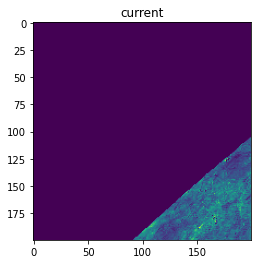

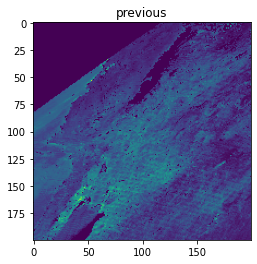

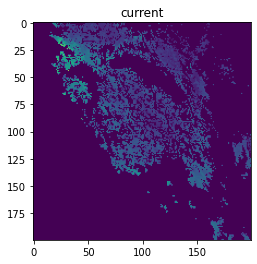

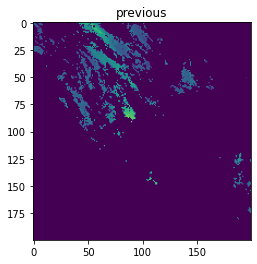

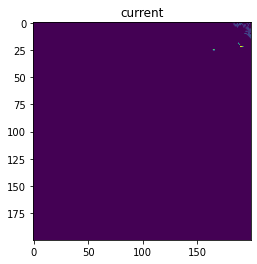

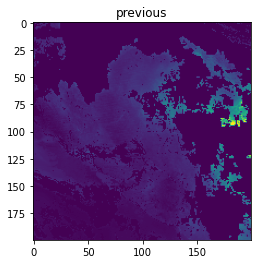

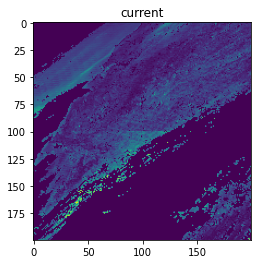

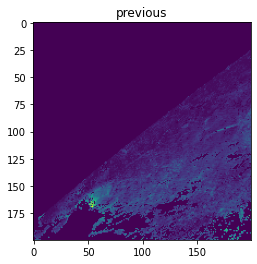

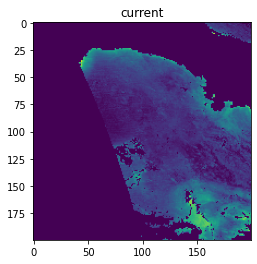

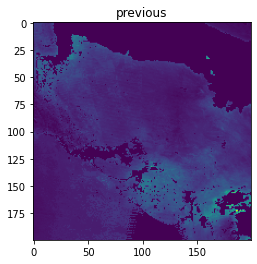

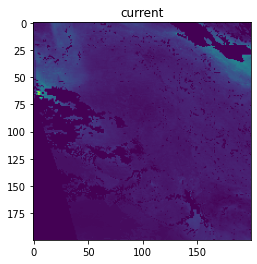

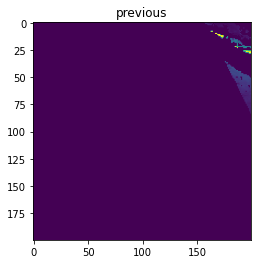

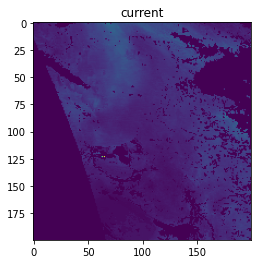

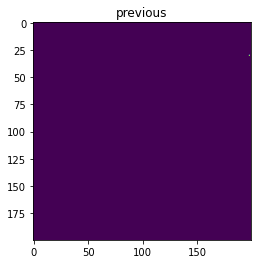

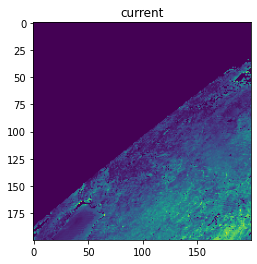

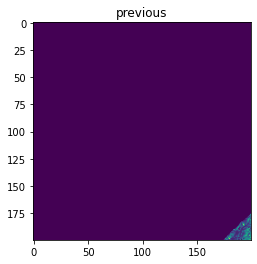

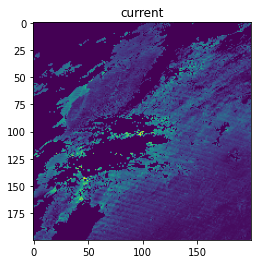

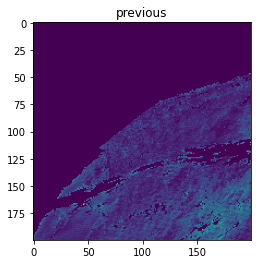

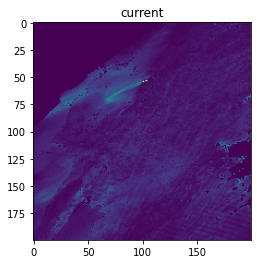

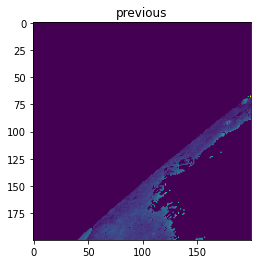

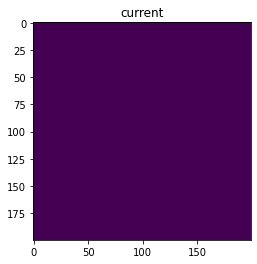

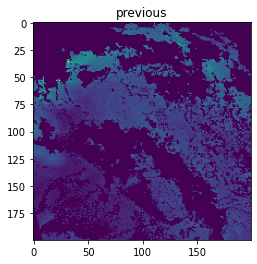

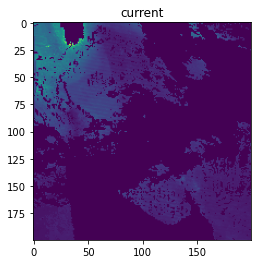

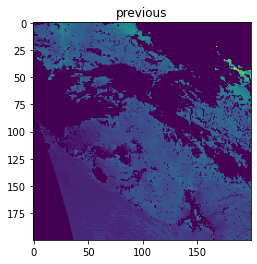

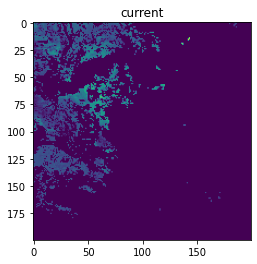

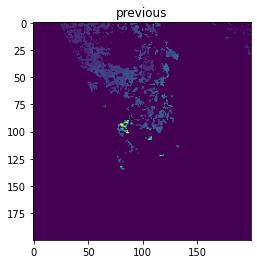

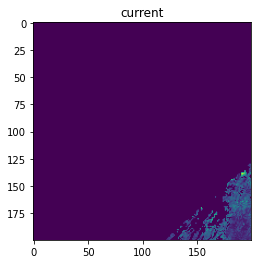

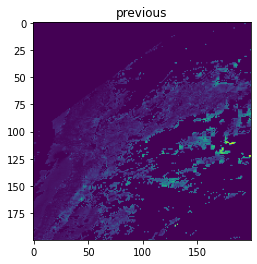

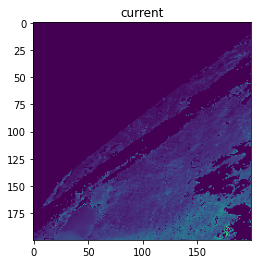

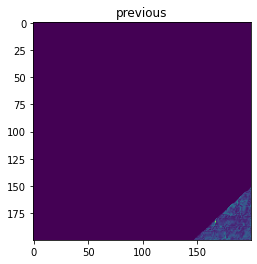

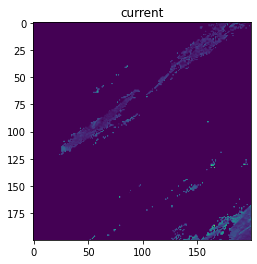

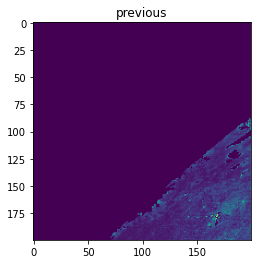

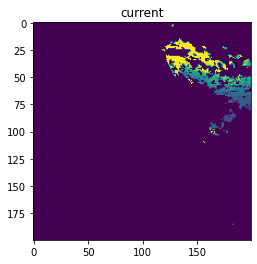

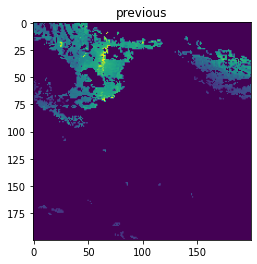

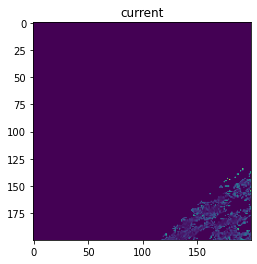

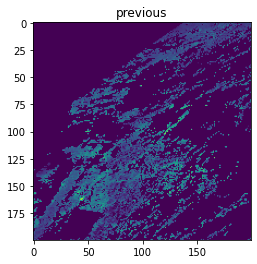

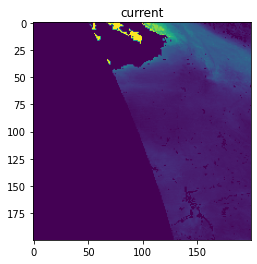

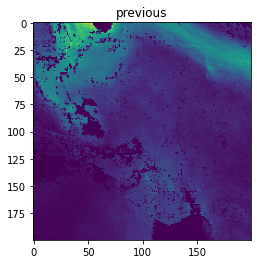

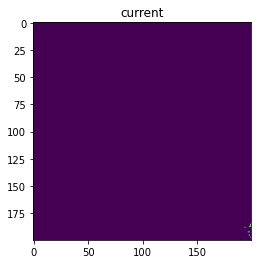

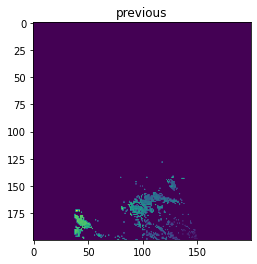

In [26]:
# print Example Images
for image1, image2 in zip(features[0:20], features_previous[0:20]):
    plt.imshow(image1)
    plt.title('current')
    plt.show()
    plt.title('previous')
    plt.imshow(image2)
    plt.show()

In [27]:
def train_model(current_image, historical_image, auxillary_features, labels):

    #Define input layer 1
    image_input1 = Input((200, 200, 1))
    conv_layer1 = Conv2D(8, (3,3), strides=1, activation='relu')(image_input1)
    max_pooling_layer1 = MaxPooling2D((2,2))(conv_layer1)
    dropout_layer1 = Dropout(0.5)(max_pooling_layer1)
    conv_layer2 = Conv2D(4, (3,3), strides=1, activation='relu')(dropout_layer1)
    flat_layer1 = Flatten()(conv_layer2)
    output = Dense(1, activation='relu')(flat_layer1)
    
    #Define input layer 2
    image_input2 = Input((200, 200, 1))
    conv_layer2_1 = Conv2D(8, (3,3), strides=1, activation='relu')(image_input2)
    max_pooling_layer2 = MaxPooling2D((2,2))(conv_layer2_1)
    dropout_layer2 = Dropout(0.5)(max_pooling_layer2)
    conv_layer2_2 = Conv2D(4, (3,3), strides=1, activation='relu')(dropout_layer2)
    flat_layer2 = Flatten()(conv_layer2_2)
    
    # Define auxillary information layer 
    auxillary_input = Input((74,))
    
    # concat layers
    concat_layer= Concatenate()([flat_layer1, flat_layer2, auxillary_input])
    dropout_combined = Dropout(0.5)(concat_layer)
    combined_dense_layer1 = Dense(16, activation='relu')(dropout_combined)
    combined_dense_layer2 = Dense(8, activation='relu')(combined_dense_layer1)
    output = Dense(1, activation='relu')(combined_dense_layer2)
 
    
    model = Model(inputs=[image_input1, image_input2, auxillary_input], outputs=output)
    #model = Model(inputs=[image_input1, image_input2], outputs=output)
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    model.summary()

    model.fit([current_image, historical_image, auxillary_features],labels, batch_size=1, epochs=30)
    #model.fit([current_image, historical_image],labels, batch_size=1, epochs=100)
    
    return model

    

In [ ]:
model = train_model(features_train, features_previous_train, auxillary_features_train, labels_train)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 198, 198, 8)  80          ['input_1[0][0]']                
                                                                                              

2022-03-20 19:24:13.996876: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-20 19:24:16.788117: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38448 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


Epoch 1/30


2022-03-20 19:24:23.445763: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-03-20 19:24:31.205677: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


13500/13500 [==============================] - 56s 3ms/step - loss: 2397.6860
Epoch 2/30
13500/13500 [==============================] - 43s 3ms/step - loss: 1493.7106
Epoch 3/30
13500/13500 [==============================] - 44s 3ms/step - loss: 1303.4200
Epoch 4/30
13500/13500 [==============================] - 44s 3ms/step - loss: 1226.8491
Epoch 5/30
13500/13500 [==============================] - 44s 3ms/step - loss: 1205.7156
Epoch 6/30
13500/13500 [==============================] - 44s 3ms/step - loss: 1137.3077
Epoch 7/30
13500/13500 [==============================] - 44s 3ms/step - loss: 1123.9259
Epoch 8/30
13500/13500 [==============================] - 44s 3ms/step - loss: 1103.1188
Epoch 9/30
13500/13500 [==============================] - 44s 3ms/step - loss: 1045.9751
Epoch 10/30
13500/13500 [==============================] - 44s 3ms/step - loss: 1000.2025
Epoch 11/30
13500/13500 [==============================] - 44s 3ms/step - loss: 1025.7106
Epoch 12/30
13500/13500 [=====

In [ ]:
model.evaluate([features_test, features_previous_test, auxillary_features_test], labels_test)

In [60]:
#model.save('./saved_models/')

In [ ]:
#model = keras.models.load_model('./saved_models/')

### Submission

In [ ]:
sub = pd.read_csv("./Data/submission_format.csv")

In [ ]:
pred = []
for x in np.array_split(sub, 10):
    print("DONE")
    df = pd.DataFrame(x)
    features, labels = generate_features(df, "test", n_days_previous=None)
    features_previous, labels = generate_features(df, "test", n_days_previous=1)
    auxillary_features = generate_auxillary_features(df, split='test')
    predictions = model.predict([features, features_previous, auxillary_features])
    pred.extend(predictions) 

In [ ]:
sub['value'] = [x[0] for x in pred]
sub.head(50)

In [ ]:
sub.to_csv("./Data/submission_10_ntj.csv", header=True, index=False)